In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-housing-market-factors/Annual_Macroeconomic_Factors.csv
/kaggle/input/usa-housing-market-factors/Housing_Macroeconomic_Factors_US (2).csv
/kaggle/input/usa-housing-market-factors/Monthly_Macroeconomic_Factors.csv


> ## **`📝 NOTE`**  
> #### This is a work in progress. Feel free to comment or suggest. Happy Learning!! 
Also, this notebook and dataframe are heavily influenced by [this GitHub repo](https://github.com/daksh-intwala/House-Price-Prediction--Regression-Anaylsis) by /@daksh-intwala on GitHub.


# Table of Contents: 
1. About the dataset
2. Data Preprocessing & Visualization
3. Data Modelling

# 1. About the dataset
![Home](https://images.unsplash.com/photo-1573003139034-1693385f21a6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)
<center><i>Photo by <a href="https://unsplash.com/es/@rosssneddon?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ross Sneddon</a> on <a href="https://unsplash.com/s/photos/american-houses?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></i></center>

The data in this dataset is collected from [FRED](https://fred.stlouisfed.org/). I decided to create this dataset after reading the research papers [`Factors Affecting House Prices in Cyprus: 1988-2008`](https://www.researchgate.net/publication/228632026_Factors_Affecting_House_Prices_in_Cyprus_1988-2008) by Panos Pashardes & Christos S. Savva & [`A Framework For Analysing House Prices Using Time, Space And
Quality Criteria`](https://www.eres.org/eres2010/contents/papers/eres2010_119_Herath_A_FRAMEWORK_FOR_ANAL.pdf) by Shanaka Herath†, Gunther Maier. These research papers are extremely informative and covers a lot of details regarding the microeconomics & macroeconomics involved in real estate market. So I would recommend you all to go through it once. 

#### NOTE:
This dataset will be updated over a period of time and include the following:
- **Macroeconomic factors** with quarterly, monthly frequencies.
- **Microeconomic factors** such as house type, age, location, size (BR, BA, carpet area/built-up area), facilities, view, disability functions, region, house prices, etc.

----- 

### What can you do with this dataset?
- Perform statistical analysis, find significant features & find the value by which these features affect the house price index (recommend to use a percentage change instead of index).
- Perform multivariate regression and predict the price of houses using microeconomic features (soon).

# 2. Data Preprocessing & Visualization

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data prep & modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
%matplotlib inline

In [3]:
path = '../input/usa-housing-market-factors/Housing_Macroeconomic_Factors_US (2).csv'
macro = pd.read_csv(path, parse_dates=['Date'])

In [4]:
print(macro.shape)
print('='*20)
print(macro.info())
print('='*20)
print(macro.describe())


(425, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               425 non-null    datetime64[ns]
 1   house_price_index  425 non-null    float64       
 2   population         425 non-null    int64         
 3   house_supply       425 non-null    float64       
 4   gdp                422 non-null    float64       
 5   mortgage_rate      422 non-null    float64       
 6   employment_rate    422 non-null    float64       
 7   permit_new         422 non-null    float64       
 8   ppi_res            422 non-null    float64       
 9   m3                 422 non-null    float64       
 10  cci                422 non-null    float64       
 11  delinquency_rate   374 non-null    float64       
 12  hcai               285 non-null    float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usag

- Since I can't produce the missing historical values of delinquency rate and hcai, I think it is better to drop those rows with missing values.

In [5]:
macro = macro.dropna().set_index('Date')
macro.head(4)

,house_price_index,population,house_supply,gdp,mortgage_rate,employment_rate,permit_new,ppi_res,m3,cci,delinquency_rate,hcai
Date,,,,,,,,,,,,
1998-01-01,87.616,274732,4.0,99.994570,6.9940,73.705376,1555.0,137.3,4.0562,102.5385,2.16,10.024
1998-02-01,88.004,274943,3.9,99.980549,7.0425,73.776106,1647.0,137.5,4.0889,102.7129,2.16,10.024
1998-03-01,88.443,275175,4.1,99.975298,7.1275,73.798698,1605.0,137.5,4.1143,102.7210,2.16,10.024
1998-04-01,88.879,275434,4.0,99.984454,7.1400,73.869665,1547.0,137.9,4.1402,102.6981,2.03,9.668


#### *Observations*


### Correlation matrix of the macroeconomic factors

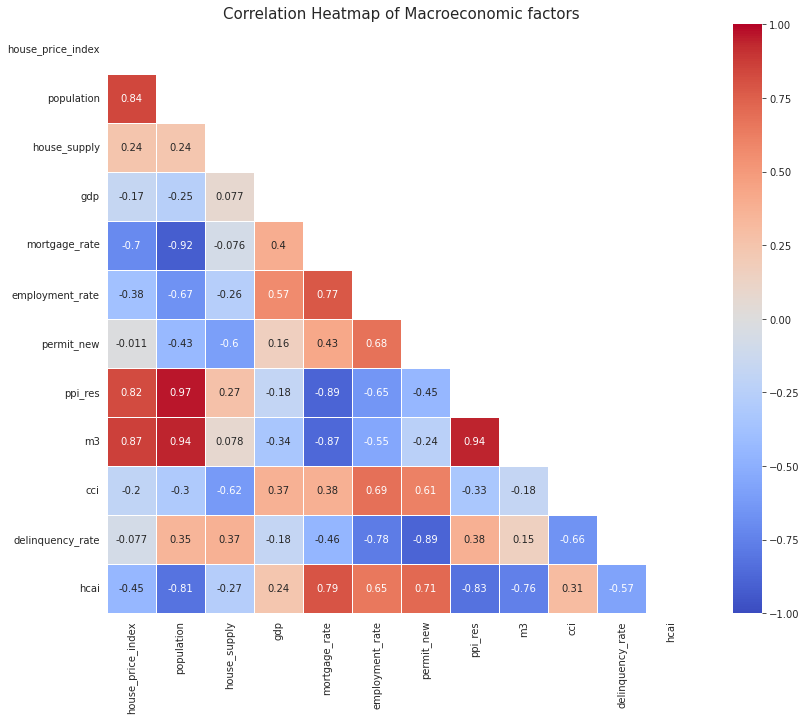

In [6]:
macrosd_corr = macro.corr()
mask = np.zeros_like(macrosd_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(macrosd_corr, mask=mask, vmax=1, vmin=-1, linewidths=.5, square=True, cmap='coolwarm', annot=True)
    plt.title('Correlation Heatmap of Macroeconomic factors', fontsize = 15)
    plt.yticks(rotation=0)
    plt.tight_layout()

#### *Observations:*
- HPI (house_price_index) has a very strong positive linear relationship with Population, Producer Price Index involved with Residential Construction (ppi_res) & m3
- It also has a strong negative linear relationship with mortgage_rate.
- But, we can note, that Population has even stronger positive relationship with ppi_res and m3, while a strong negative relationship with mortgage_rate.

##### 

In [7]:
# macro = macro.reset_index()

In [8]:
# # NEED TO UPDATE THIS, THE UNITS ARE ALL OVER THE PLACE

# i,j=0,0
# n,m=6,2
# fig, ax = plt.subplots(n, m, figsize=(20,20))
# for col in macro.columns[2:]:
#     if i!=n:
#         ax1 = macro.plot(x='Date', y=col, ax=ax[i, j], color='b', legend=False)
#         ax[i,j].set_ylabel(col, fontsize=12, color='b')
#         ax2 = macro.plot(x='Date', y='house_price_index', ax=ax1.twinx(), color='r', legend=False)
#         ax2.set_ylabel('house_price_label',color='r',fontsize=12, rotation=270)

#         j+=1
#         if j == m:
#             i+=1
#             j=0 
#     plt.tight_layout()
# plt.show()


# 3. Data Modelling

### Normalizing to scale the features (Feature Scaling)

In [11]:
macro_df = macro.copy().reset_index()
macro_df = macro_df.drop(columns=['Date'])

In [12]:
scaler = MinMaxScaler()
n_macro=pd.DataFrame(scaler.fit_transform(macro_df), columns=macro_df.columns, index=macro_df.index) 
n_macro.head(4)

,house_price_index,population,house_supply,gdp,mortgage_rate,employment_rate,permit_new,ppi_res,m3,cci,delinquency_rate,hcai
0,0.000000,0.000000,0.078652,0.821908,0.739153,0.943701,0.595429,0.001452,0.000000,0.932625,0.076305,0.396848
1,0.002124,0.003659,0.067416,0.820545,0.747470,0.948666,0.648000,0.002905,0.001931,0.959385,0.076305,0.396848
2,0.004528,0.007682,0.089888,0.820034,0.762048,0.950251,0.624000,0.002905,0.003431,0.960628,0.076305,0.396848
3,0.006915,0.012172,0.078652,0.820924,0.764191,0.955233,0.590857,0.005810,0.004960,0.957114,0.063253,0.378574


### Splitting the dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(n_macro.drop(columns="house_price_index", axis=1), n_macro["house_price_index"], test_size= 0.30, random_state=42)

### Performing and evaluating various regression models

In [14]:
# define evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# defining the model
model1 = Lasso(alpha=1.0)
scores1 = cross_val_score(model1, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores1 = np.absolute(scores1)

print('Mean MAE: %.3f (%.3f)' % (np.mean(scores1), np.std(scores1)))

Mean MAE: 0.167 (0.027)


In [15]:
model2 = Ridge(alpha=1.0)
scores2 = cross_val_score(model2, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores2 = np.absolute(scores2)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores2), np.std(scores2)))

Mean MAE: 0.024 (0.004)


In [16]:
model3 = BayesianRidge()
scores3 = cross_val_score(model3, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores3 = np.absolute(scores3)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores3), np.std(scores3)))

Mean MAE: 0.019 (0.003)


In [17]:
model4 = LinearRegression()
scores4 = cross_val_score(model4, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores4 = np.absolute(scores4)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores4), np.std(scores4)))

Mean MAE: 0.019 (0.003)


In [18]:
model5 = ElasticNet()
scores5 = cross_val_score(model5, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores5 = np.absolute(scores5)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores5), np.std(scores5)))

Mean MAE: 0.167 (0.027)


Here, BayesianRidge & Linear Regression had the best score. Chose BayesianRidge for further optimization

### Hyperparameter Selection

In [19]:
clf = GridSearchCV(BayesianRidge(),{
    'alpha_1':list(range(0,10,1)),
    'alpha_2':list(range(0,10,1)),
    'lambda_1':list(range(0,10,1)),
    'lambda_2':list(range(0,10,1))

}, cv=5, return_train_score=False )

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=BayesianRidge(),
             param_grid={'alpha_1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'alpha_2': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'lambda_1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'lambda_2': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [20]:
param_df = pd.DataFrame(clf.cv_results_)
param_df.head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha_1,param_alpha_2,param_lambda_1,param_lambda_2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002871,0.000752,0.001752,0.000105,0,0,0,0,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968404,0.983701,0.985508,0.988016,0.989245,0.982975,0.007537,6040
1,0.002457,0.000157,0.001744,0.000105,0,0,0,1,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968477,0.983286,0.985306,0.987991,0.989304,0.982873,0.007495,6594
2,0.002620,0.000346,0.001702,0.000061,0,0,0,2,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968486,0.983227,0.985277,0.987988,0.989311,0.982858,0.007490,6806
3,0.002554,0.000251,0.001683,0.000018,0,0,0,3,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968489,0.983203,0.985266,0.987986,0.989314,0.982851,0.007488,6995


In [21]:
max_test_score = np.max(param_df["mean_test_score"])
print(max_test_score)

0.9832190218864664


In [22]:
param_df[param_df['mean_test_score']==max_test_score]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha_1,param_alpha_2,param_lambda_1,param_lambda_2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
806,0.002512,0.000138,0.001675,0.000016,0,8,0,6,"{'alpha_1': 0, 'alpha_2': 8, 'lambda_1': 0, 'l...",0.967912,0.985051,0.986235,0.988017,0.98888,0.983219,0.007769,1


In [23]:
print('''Hyper Parameters are:
            alpha_1: {}
            alpha_2: {}
            
            lambda_1: {}
            lambda_2: {}'''.format(param_df["param_alpha_1"][806], param_df["param_alpha_2"][806], param_df["param_lambda_1"][806], param_df["param_lambda_2"][806]))

Hyper Parameters are:
            alpha_1: 0
            alpha_2: 8
            
            lambda_1: 0
            lambda_2: 6


### Model Fitting

In [24]:
# Model Defining and Fitting
model_br= BayesianRidge(alpha_1=0, alpha_2=1, lambda_1=9, lambda_2=9)
fit_data = model_br.fit(X_train, y_train)

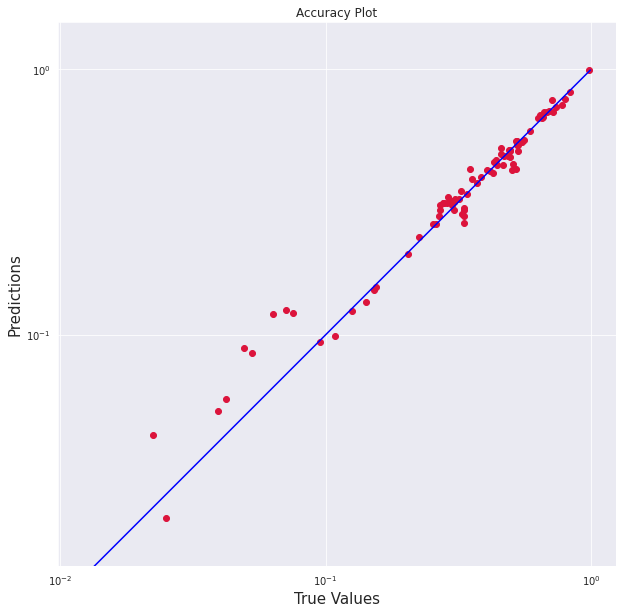

In [25]:
# Prediction

prediction = fit_data.predict(X_test)

# Plotting both the curves simultaneously
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Accuracy Plot")
plt.axis('equal')
plt.show()

### Bias-Variance Check

In [26]:
from mlxtend.evaluate import bias_variance_decomp
X_tr = X_train.to_numpy(dtype ='float32')
X_tst = X_test.to_numpy(dtype ='float32')
y_tr = y_train.to_numpy(dtype ='float32')
y_tst = y_test.to_numpy(dtype ='float32')

mse, bias, variance = bias_variance_decomp(model_br, X_tr, y_tr, X_tst, y_tst, 
                                           loss='mse', num_rounds=200, random_seed=123)
print("Average Bias : ", bias)
print("Average Variance : ", variance)

Average Bias :  0.0009344158092976996
Average Variance :  4.20425593559234e-05


In [27]:
rmse=np.sqrt(mean_squared_error(y_test, prediction))
print('RMSE: ', rmse)
r2 = r2_score(y_test, prediction)
print('R squared: ', r2)

RMSE:  0.030622590435954705
R squared:  0.9799314600892053


### OLS using statsmodel

In [28]:
result = sm.OLS(y_train, X_train).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:      house_price_index   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              5856.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):                   6.55e-232
Time:                        03:55:32   Log-Likelihood:                          459.94
No. Observations:                 199   AIC:                                     -897.9
Df Residuals:                     188   BIC:                                     -861.7
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

- ```Here, the model shows that cci aka Consumer Confidence Index has no relationship with the target house_price_index since it fails to rejects the null hypothesis (there's no relationship) i.e., p values > 0.005. Alternative hypothesis being 'some relationship exists' is true for the rest of the features.```

- This model also shows that the 99.7% (r squares = 0.997) of the variability of house price index can be explained by it's independent features. 

